In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import kaggle
from pathlib import Path
from PIL import Image
import kagglehub
from collections import Counter
import zipfile
import os
from PIL import Image

In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [3]:
path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
path+='\Mushrooms'
print("Path to dataset files:", path)

Path to dataset files: C:\Users\sosno\.cache\kagglehub\datasets\maysee\mushrooms-classification-common-genuss-images\versions\1\Mushrooms


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])
# broken
broken_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith(('.jpg', '.png', '.jpeg')):
            path_file = os.path.join(root, file)
            try:
                with Image.open(path_file) as img:
                    img.verify()  # Проверяем целостность
            except Exception as e:
                print(f"Broken: {path_file}")
                broken_files.append(path_file)
                os.remove(path_file)  # Удаляем битый файл
print(f"Removed {len(broken_files)} broken files")
dataset = ImageFolder(path, transform=transform)
print(len(dataset))
for i in range(5400, len(dataset)):
    try:
        img, label = dataset[i]
    except Exception as e:
        print(f"Error at index {i}: {e}")
        broken_path = dataset.samples[i][0]  # путь к битому файлу
        print(f"Broken file: {broken_path}")
        # Удалить файл
        os.remove(broken_path)


dataset = ImageFolder(path, transform=transform)
batch_size = 32

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

indices = torch.randperm(len(dataset)).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

#train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_dataset), len(test_dataset))
train_labels = [dataset.targets[i] for i in train_dataset.indices]
class_weights = 1. / torch.bincount(torch.tensor(train_labels))
sample_weights = class_weights[train_labels]
sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler = sampler, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(test_loader))

Removed 0 broken files
6713
5370 1343
42


In [5]:
print(f"Dataset length: {len(dataset)}")
print(f"Train indices range: {min(train_dataset.indices)}-{max(train_dataset.indices)}")
print(f"Test indices range: {min(test_dataset.indices)}-{max(test_dataset.indices)}")

Dataset length: 6713
Train indices range: 0-6712
Test indices range: 9-6710


In [6]:
dataiter = iter(train_loader)
obj,l = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


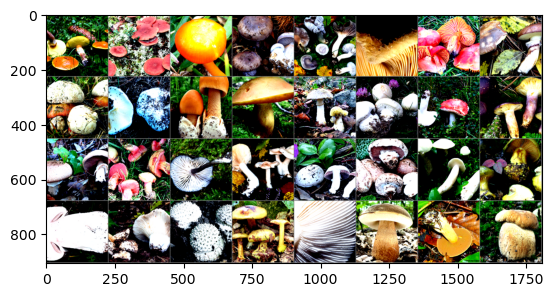

8 6 5 3 5 6 5 8 2 6 1 2 1 0 7 7 0 8 4 4 0 0 8 3 0 7 1 3 7 2 8 2


In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
for i in range(1):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)

    imshow(torchvision.utils.make_grid(images))
    print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [8]:
class CNN(nn.Module):
    def __init__(self, num_classes= 10, dropout_rate = 0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding = 1, stride = 1), nn.ReLU(), #112
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding = 1, stride = 1), nn.ReLU(), #56
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding = 1, stride = 1), nn.ReLU(), #28
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding = 1, stride = 1), nn.ReLU(), #14
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, padding = 1, stride = 1), nn.ReLU(), #7
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 1024), nn.Sigmoid(), nn.Dropout(dropout_rate),
            nn.Linear(1024, num_classes)
        )
    def forward(self,x):
        return self.classifier(self.features(x))

In [9]:
model = CNN(num_classes = 10, dropout_rate = 0.2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(num_epoch = 10, patience=5):

    torch.cuda.empty_cache()
    
    best_accuracy = 0.0
    trigger_counter = 0
    
    for epoch in range(num_epoch):
        model.train()
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs,labels)
            epoch_loss+=loss.item()
            loss.backward()
            optimizer.step()

            if i%50==49:
                print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {epoch_loss / 100:.3f}')
        model.eval()
        val_loss,correct, total = 0,0,0
        with torch.no_grad():
            for images,labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss+=loss.item()

                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        
        avg_val_loss = val_loss/len(test_loader)
        accuracy = 100 * correct / total
        
        # callbacks
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            trigger_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
            }, "best_CNN_trained.pth")
        else:
            trigger_counter += 1
            if trigger_counter >= patience:
                break
    print("Done!")
    
    checkpoint = torch.load("best_CNN_trained.pth",weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    accuracy = checkpoint['accuracy']
    
    print(f'Model showed the best validation accuracy = {accuracy}% on epoch {epoch}')

In [ ]:
train(30)

Epoch 1, Batch 50, Loss: 1.120
Epoch 1, Batch 100, Loss: 2.137
Epoch 1, Batch 150, Loss: 3.120
Epoch 2, Batch 50, Loss: 0.954
Epoch 2, Batch 100, Loss: 1.872
Epoch 2, Batch 150, Loss: 2.772
Epoch 3, Batch 50, Loss: 0.863
Epoch 3, Batch 100, Loss: 1.685
Epoch 3, Batch 150, Loss: 2.490
Epoch 4, Batch 50, Loss: 0.692
Epoch 4, Batch 100, Loss: 1.334
Epoch 4, Batch 150, Loss: 1.901
Epoch 5, Batch 50, Loss: 0.500
Epoch 5, Batch 100, Loss: 0.972
Epoch 5, Batch 150, Loss: 1.378
Epoch 6, Batch 50, Loss: 0.333
Epoch 6, Batch 100, Loss: 0.620
Epoch 6, Batch 150, Loss: 0.902
Epoch 7, Batch 50, Loss: 0.235
Epoch 7, Batch 100, Loss: 0.439
Epoch 7, Batch 150, Loss: 0.613
Epoch 8, Batch 50, Loss: 0.158
Epoch 8, Batch 100, Loss: 0.306
Epoch 8, Batch 150, Loss: 0.420
Epoch 9, Batch 50, Loss: 0.110
Epoch 9, Batch 100, Loss: 0.204
Epoch 9, Batch 150, Loss: 0.315
Epoch 10, Batch 50, Loss: 0.081
Epoch 10, Batch 100, Loss: 0.153
Epoch 10, Batch 150, Loss: 0.225
Epoch 11, Batch 50, Loss: 0.067
Epoch 11, Batch

In [14]:
model = CNN(10,0.2).to(device)
checkpoint = torch.load("best_CNN_trained.pth",weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
print(accuracy)
model.eval()
correct, total = 0,0
with torch.no_grad():
    for images,labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(correct, total)
assert total == len(test_dataset)

accuracy = 100 * correct / total
print(f'Accuracy on test: {accuracy}%')

41.102010424422936
1167 1343
Accuracy on test: 86.89501116902457%
